<a href="https://colab.research.google.com/github/LEEINSEO-0118/Seed-size-calculator/blob/main/CalculateSize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import


# Calculate Functions

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

## Standard Template
사이즈 비교의 대상이 되는 템플릿


In [3]:
# 실제로 사용한 30mm x 30mm 사이즈의 종이 템플릿을 30배 스케일로 늘려 템플릿 생성
SCALE = 30
PAPER_W = 30 * SCALE
PAPER_H = 30 * SCALE

paper_coords = np.float32([[0,0],                # Top left
                           [PAPER_W,0],          # Top right
                           [0,PAPER_H],          # Bottom left
                           [PAPER_W,PAPER_H]])   # Bottom right

## Load Image and Show Image

In [4]:
def load_image(path, scale = 0.7):
    img = cv2.imread(path)
    img_resized = cv2.resize(img, (0,0), None, scale, scale)
    return img_resized

def show_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.xticks([])
    plt.yticks([]) # 얘네 넣으면 축에 index가 사라지네?
    plt.imshow(img)
    plt.show()

## Image Preprocess
이미지 -> 그레이 스케일 -> Blur 처리 -> edge 추출 -> edge굵게 및 선명하게

In [5]:
def preprocess_image(img, thresh_1=57, thresh_2=232):
    img_gray  = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)      # 그레이 스케일 변환
    img_blur  = cv2.GaussianBlur(img_gray, (5,5), 1)       # 필터처리
    img_canny = cv2.Canny(img_blur, thresh_1, thresh_2)    # edge detector

    kernel = np.ones((3,3))    #4
    img_dilated = cv2.dilate(img_canny, kernel, iterations=1)    # edge 라인을 굵게
    img_closed = cv2.morphologyEx(img_dilated, cv2.MORPH_CLOSE,
                                  kernel, iterations=4)          # edge 내부 small holes 제거, edge를 명확하게

    img_preprocessed = img_closed.copy()

    img_each_step = {'img_dilated': img_dilated,
                     'img_canny'  : img_canny,
                     'img_blur'   : img_blur,
                     'img_gray'   : img_gray}

    return img_preprocessed, img_each_step

## Find Contours
Contour를 통해 모서리 추출

In [26]:
def find_contours(img_preprocessed, img_original, epsilon_param=0.04):
    contours, hierarchy = cv2.findContours(image=img_preprocessed,
                                           mode=cv2.RETR_EXTERNAL, # for outermost contours
                                           method=cv2.CHAIN_APPROX_NONE)  # find contour

    img_contour = img_original.copy() # copy origin image
    cv2.drawContours(img_contour, contours, -1, (203,192,255), 6)  # draw contour on copied origin image

    polygons = []
    for contour in contours:
        epsilon = epsilon_param * cv2.arcLength(curve=contour,
                                                closed=True)  # epsilon 값이 작으면 많은 코너를 탐지한다.
                                                              # 사이즈 기준 객체의 정확한 코너를 찾기 위해서 epsilon 값을 설정하는 것에 주의해야 함
        polygon = cv2.approxPolyDP(curve=contour,
                                   epsilon=epsilon, closed=True)  # contour를 통해 코너(Curves) 추정
        print(polygon.shape)
        polygon = polygon.reshape(4, 2)  # original output of cv2.approxPolyDP() is in the format (number of corners, 1, 2), where the middle axis is irrelevant in our case. Hence, we can safely discard it.
        print(polygon.shape)
        print(polygon)
        polygons.append(polygon)
        for point in polygon:
            img_contour = cv2.circle(img=img_contour, center=point,
                                     radius=8, color=(0,240,0),
                                     thickness=-1)
        break

    # contour = contours[-1]
    # epsilon = epsilon_param * cv2.arcLength(curve=contour,
    #                                         closed=True)  # epsilon 값이 작으면 많은 코너를 탐지한다.
    #                                                         # 사이즈 기준 객체의 정확한 코너를 찾기 위해서 epsilon 값을 설정하는 것에 주의해야 함
    # polygon = cv2.approxPolyDP(curve=contour,
    #                             epsilon=epsilon, closed=True)  # contour를 통해 코너(Curves) 추정
    # print(polygon.shape)
    # polygon = polygon.reshape(4, 2)  # original output of cv2.approxPolyDP() is in the format (number of corners, 1, 2), where the middle axis is irrelevant in our case. Hence, we can safely discard it.
    # print(polygon.shape)
    # print(polygon)
    # polygons.append(polygon)
    # for point in polygon:
    #     img_contour = cv2.circle(img=img_contour, center=point,
    #                                 radius=8, color=(0,240,0),
    #                                 thickness=-1)


    return polygons, img_contour

모서리 좌표 순서 정렬

In [7]:
def reorder_coords(polygon):
    rect_coords = np.zeros((4, 2)) # 각 모서리 구해서 넣기

    # 왼쪽 상단이 0, 0
    # 좌표 합 가장 작은 것 -> 좌측 상단
    # 좌표 합 가장 큰 것 -> 우측 하단
    add = polygon.sum(axis=1) # 컬럼을 기준으로 합치기
    rect_coords[0] = polygon[np.argmin(add)]    # Top left # 최소값의 index 반환
    rect_coords[3] = polygon[np.argmax(add)]    # Bottom right

    # 차 y - x
    # 좌표 차 가장 작은 것 -> 우측 상한
    # 좌표 차 가장 큰 것 -> 좌측 하단
    subtract = np.diff(polygon, axis=1)
    rect_coords[1] = polygon[np.argmin(subtract)]    # Top right
    rect_coords[2] = polygon[np.argmax(subtract)]    # Bottom left

    return rect_coords

## Perspective Transform

호모그래피 추출 및 원근 변환

In [8]:
def warp_image(rect_coords, paper_coords, img_original, pad=25):

    # 실제 이미지에서 template으로 변환하는 homography 생성
    matrix, _ = cv2.findHomography(rect_coords, paper_coords)

    # trasform
    img_warped = cv2.warpPerspective(img_original, matrix,
                                        (PAPER_W, PAPER_H))

    # 이미지가 원하지 않는 영역을 가지기에 pad 만큼 그것을 제거
    # 음.. 꼭 해야하나..?
    # -> 이거 안하니까 계산기 corner가 안 찾아짐... 미친.. 왜?
    warped_h = img_warped.shape[0]
    warped_w = img_warped.shape[1]
    img_warped = img_warped[pad:warped_h-pad, pad:warped_w-pad]

    return img_warped

## Find Ellipse contours

종실 형태를 기준으로 타원을 형성 -> 타원을 기준으로 Rotated된 직사각형 생성 -> 종실의 크기 측정

In [9]:
def find_ellipse_contours(img_preprocessed, img_original):

    thresh_1, thresh_2 = 57, 232
    canny_output = cv2.Canny(img_preprocessed, thresh_1, thresh_2)
    contours, hierarchy = cv2.findContours(image=img_preprocessed,
                                           mode=cv2.RETR_EXTERNAL, # for outermost contours
                                           method=cv2.CHAIN_APPROX_NONE)  # find contour

    # Find the rotated rectangles and ellipses for each contour
    minRect = [None]*len(contours)
    for i, c in enumerate(contours):
        minRect[i] = cv2.minAreaRect(c)
    print(minRect)

    img_contour = img_original.copy()

    polygons = cv2.boxPoints(minRect[i])
    polygons = np.intp(polygons) #np.intp: Integer used for indexing (same as C ssize_t; normally either int32 or int64)
    cv2.drawContours(img_contour, [polygons], -1, (255,0,0), 3)

    for point in polygons:
        img_contour = cv2.circle(img=img_contour, center=point, radius=8, color=(0,240,0), thickness=-1)

    return img_contour, polygons

## Calculate size

In [10]:
def calculate_sizes(polygons):
    sizes = []
    lens = len(polygons)
    for i in range(lens):
        for j in range(i+1, lens):
            dist = cv2.norm(polygons[i], polygons[j], cv2.NORM_L2)
            sizes.append([dist, [i, j]]) # 길이와 두 점의 index 저장

    sorted_sizes = sorted(sizes, key=lambda x: x[0])

    result = [sorted_sizes[0], sorted_sizes[3]]
    return result

In [11]:
def convert_to_mm(sizes_pixel, img_warped):
    warped_h = img_warped.shape[0]
    warped_w = img_warped.shape[1]

    scale_h = PAPER_H / warped_h    # 높이 비율
    scale_w = PAPER_W / warped_w    # 너비 비율


    size_pixel_h, size_pixel_w = sizes_pixel[0][0], sizes_pixel[1][0]
    size_mm_h = size_pixel_h * scale_h / SCALE
    size_mm_w = size_pixel_w * scale_w / SCALE

    sizes_mm = [[size_mm_h, sizes_pixel[0][1]], [size_mm_w, sizes_pixel[1][1]]]

    return sizes_mm

## Print size

In [12]:
def write_size(polygons, sizes, img_warped):

    img_result = img_warped.copy()
    for size, idx in (sizes):
        cv2.line(img_result, polygons[idx[0]], polygons[idx[1]], (0,0,255), 4)
        cv2.putText(img_result, f'{np.float32(size):.2f}mm',
                    (polygons[idx[0]][0]-50, polygons[idx[0]][1]+100),
                    cv2.FONT_HERSHEY_DUPLEX, 0.9, (0,0,255), 1)

    return img_result

## Total Function

In [13]:
def measure_size(path, img_original_scale=0.7,
                 PAPER_W=30, PAPER_H=30, SCALE=30,
                 paper_eps_param=0.04,canny_thresh_1=57, canny_thresh_2=232):

    PAPER_W = PAPER_W * SCALE
    PAPER_H = PAPER_H * SCALE

    # Loading and preprocessing original image.
    img_original = load_image(path=path, scale=img_original_scale)
    img_preprocessed, img_each_step = preprocess_image(img_original,
                                                       thresh_1=canny_thresh_1,
                                                       thresh_2=canny_thresh_2)

    # Finding paper contours and corners.
    polygons, img_contours = find_contours(img_preprocessed,
                                           img_original,
                                           epsilon_param=paper_eps_param)
    show_image(img_contours)
    # Reordering paper corners.
    rect_coords = np.float32(reorder_coords(polygons[0]))

    # Warping image according to paper contours.
    paper_coords = np.float32([[0,0],
                               [PAPER_W,0],
                               [0,PAPER_H],
                               [PAPER_W,PAPER_H]])
    img_warped = warp_image(rect_coords, paper_coords, img_original)

    # Preprocessing the warped image.
    img_warped_preprocessed, _ = preprocess_image(img_warped)

    # Finding seed rectangle
    img_contours_warped, polygons = find_ellipse_contours(img_warped_preprocessed, img_warped)


    # Edge langth calculation.
    seed_size = calculate_sizes(polygons)
    sizes_mm = convert_to_mm(seed_size, img_warped)
    img_result = write_size(polygons, sizes_mm, img_warped)

    return img_result, sizes_mm

# Calculate Images

## Make DataFrame

In [14]:
cols = ['knu_num', 'species', 'long', 'short', 'weight']
df = pd.DataFrame(columns=cols)

In [36]:
labels = []
for i in range(1, 9):
    labels.append(f'test_{i}')

In [37]:
path = f'/content/drive/MyDrive/졸업논문/data/origin_image/'
file_lists = os.listdir(path)
if len(labels) == len(file_lists):
    print('Correct')

Correct


test_1
(4, 1, 2)
(4, 2)
[[ 413   84]
 [ 321  796]
 [1110  863]
 [1169  146]]


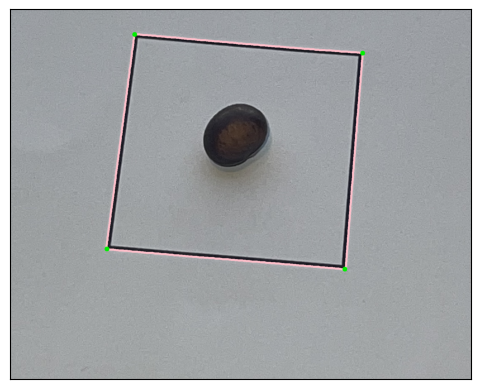

[((411.50006103515625, 365.5), (236.1736602783203, 278.6000671386719), 45.0)]


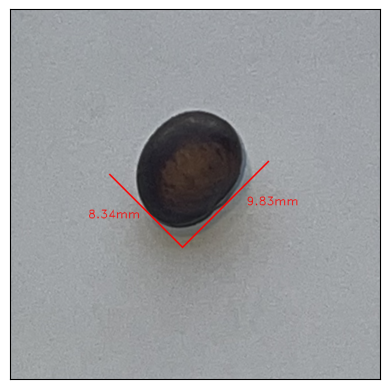

test_2
(4, 1, 2)
(4, 2)
[[ 454   63]
 [ 351  831]
 [1181  910]
 [1252  135]]


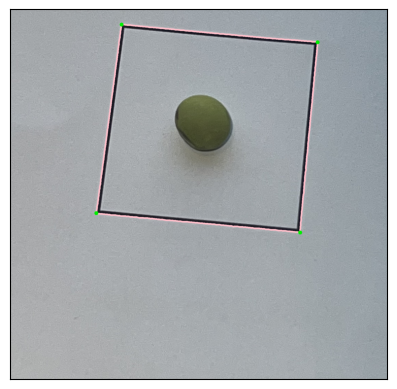

[((400.3856201171875, 410.83514404296875), (283.0094909667969, 246.22991943359375), 60.01836013793945)]


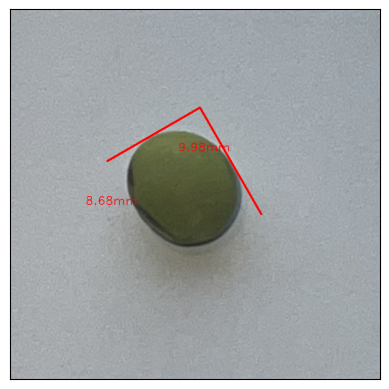

test_3
(4, 1, 2)
(4, 2)
[[ 739   73]
 [ 560  773]
 [1330  938]
 [1479  225]]


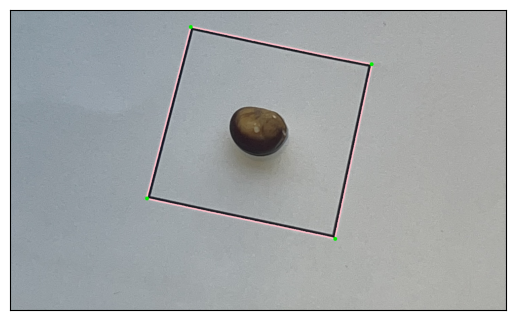

[((413.5, 435.5), (245.0, 287.0), 90.0)]


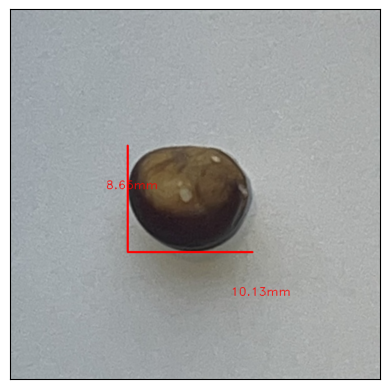

test_4
(4, 1, 2)
(4, 2)
[[ 477  126]
 [ 344 1006]
 [1321 1098]
 [1401  205]]


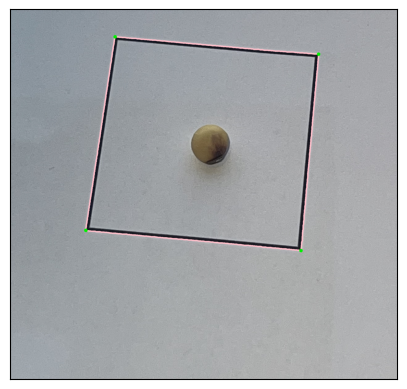

[((449.2500305175781, 440.2500305175781), (169.49807739257812, 181.8309326171875), 18.43494987487793)]


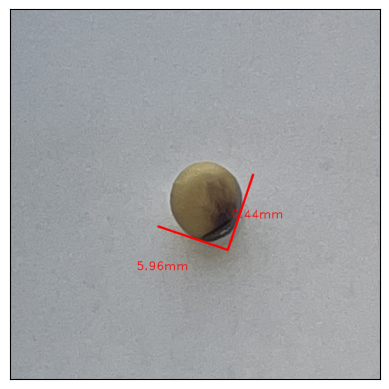

test_5
(4, 1, 2)
(4, 2)
[[ 322  121]
 [ 245  854]
 [1059  895]
 [1100  158]]


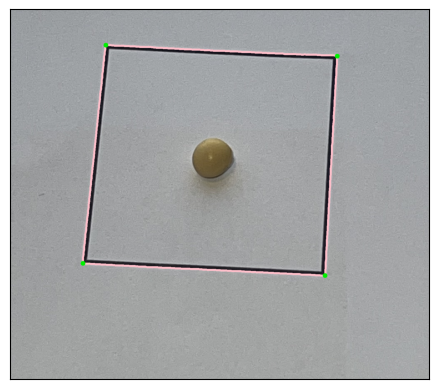

[((422.00006103515625, 427.5000305175781), (159.09902954101562, 164.75587463378906), 45.0)]


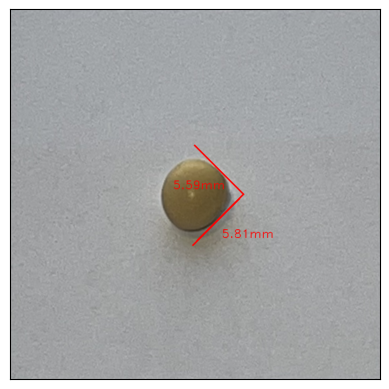

test_6
(4, 1, 2)
(4, 2)
[[ 401   89]
 [ 298  838]
 [1143  909]
 [1202  154]]


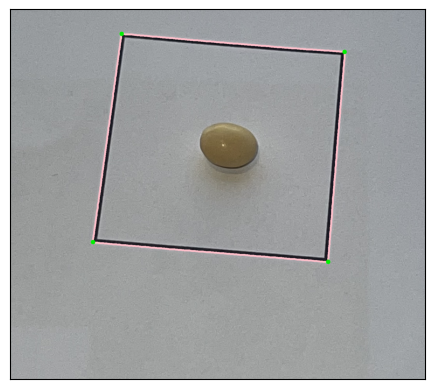

[((429.0, 427.0), (10.0, 8.0), 90.0), ((455.29034423828125, 430.0931091308594), (206.07510375976562, 219.98802185058594), 62.071014404296875)]


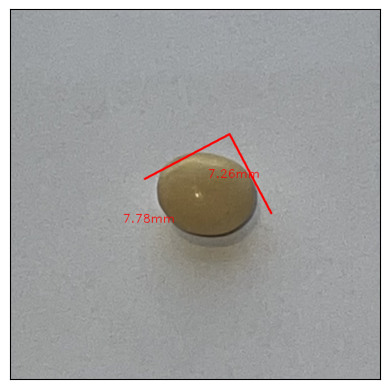

test_7
(4, 1, 2)
(4, 2)
[[ 293  109]
 [ 193  900]
 [1052  976]
 [1115  177]]


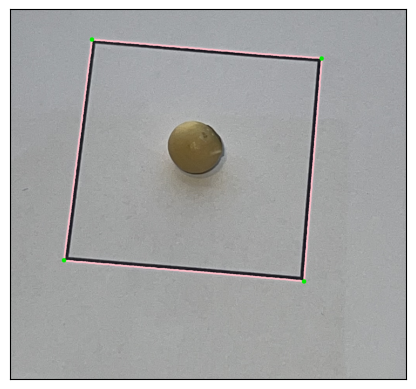

[((420.00006103515625, 385.0000305175781), (226.274169921875, 206.4751739501953), 45.0)]


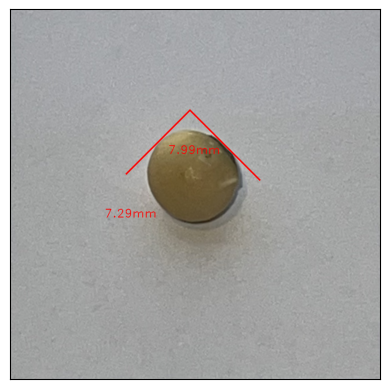

test_8
(4, 1, 2)
(4, 2)
[[ 248   83]
 [ 136  866]
 [1014  939]
 [1080  150]]


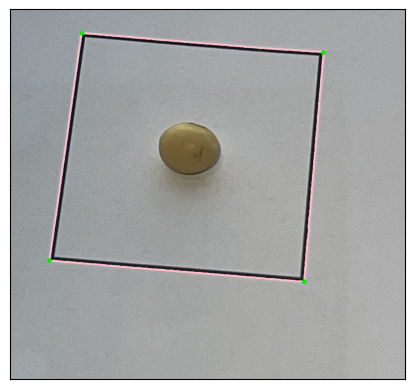

[((422.5, 404.0), (208.0, 229.0), 90.0)]


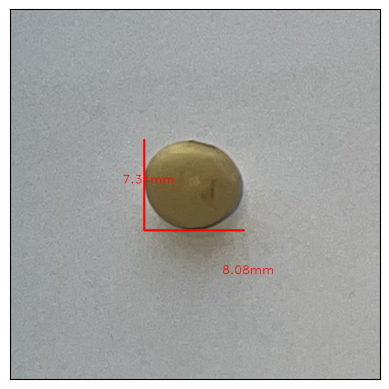

In [40]:
for label, file_name in zip(labels, file_lists):
    print(label)
    path = f'/content/drive/MyDrive/졸업논문/data/origin_image/{file_name}'
    # 사이즈 측정된 이미지와 사이즈 받기
    try :
        cal_image, sizes = measure_size(path, paper_eps_param = 0.08) # 작을 수록 많은 값을 코너를 탐지
        size_long = max(sizes[0][0], sizes[1][0])
        size_short = min(sizes[0][0], sizes[1][0])
    except:
        img = cv2.imread(path)
        cal_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        size_long = 0
        size_short = 0

    # DataFrame 구성
    temp = pd.DataFrame(data = [[label, 'species', size_long, size_short, 1.2]], columns = cols)
    df = pd.concat([df, temp])
    show_image(cal_image)

In [42]:
df

,knu_num,species,long,short,weight
0,test_1,species,9.832944,8.335541,1.2
0,test_2,species,9.976817,8.681062,1.2
0,test_3,species,10.129412,8.647059,1.2
0,test_4,species,6.439895,5.960005,1.2
0,test_5,species,5.814967,5.590303,1.2
0,test_6,species,7.783453,7.262360,1.2
0,test_7,species,7.986147,7.287359,1.2
0,test_8,species,8.082353,7.341176,1.2
